In [ ]:
# Import required libraries/packages.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from time import time
from tqdm import notebook

In [ ]:
# Check if cuda is available for use with Torch. 

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("PyTorch CUDA Support:", torch.backends.cudnn.enabled)

CUDA Available: False
CUDA Version: 11.8
PyTorch CUDA Support: True


In [ ]:
#  Check that MPS is available. 

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

MPS not available because the current PyTorch install was not built with MPS enabled.


In [ ]:
# Hyperparameter variables. 

batch = 250
learning_rate = 0.0025
epochs = 20
device = 'cpu'

In [ ]:
# Define dataset transforms. Convert to tensor then standardize tensors. 
# Create training and testing datasets, then dataloaders. 

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (1))])

train_dataset = datasets.MNIST(root='./MNIST', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./MNIST', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [ ]:
# Construct feed forward neural network model from Torch base class nn.Module. 
# Use three linear layers with ReLU activation functions. 

class DNN(nn.Module): 
    def __init__(self): 
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.fc4 = nn.Linear(28*28, 100)
        self.fc5 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x): 
        x = x.view(-1, 28*28) 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.relu(self.fc4(x))
        # x = self.fc5(x)
        return(x)

In [ ]:
# Initialize model, define loss function and optimizer. 

model = DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Carry out training loop, displaying loss after every ten epochs. 

start = time()
losses = []
for epoch in notebook.tqdm(range(epochs)): 
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.2f}")
end = time()
duration = end - start
print(f'Training time was {duration/60} minutes. ')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 93.94
Epoch 2/20, Loss: 35.84
Epoch 3/20, Loss: 23.93
Epoch 4/20, Loss: 17.92
Epoch 5/20, Loss: 14.22
Epoch 6/20, Loss: 11.41
Epoch 7/20, Loss: 9.34
Epoch 8/20, Loss: 7.95
Epoch 9/20, Loss: 6.43
Epoch 10/20, Loss: 5.59
Epoch 11/20, Loss: 4.84
Epoch 12/20, Loss: 4.20
Epoch 13/20, Loss: 3.37
Epoch 14/20, Loss: 4.64
Epoch 15/20, Loss: 3.92
Epoch 16/20, Loss: 2.62
Epoch 17/20, Loss: 3.00
Epoch 18/20, Loss: 2.95
Epoch 19/20, Loss: 3.00
Epoch 20/20, Loss: 2.27
Training time was 2.4139457027117412 minutes. 


In [24]:
# Set model to evaluation mode, then test with testing dataset. 
# Calculate accuracy and generate confusion matrix. 

model.eval()
all_preds = []
all_labels = []
with torch.no_grad(): 
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

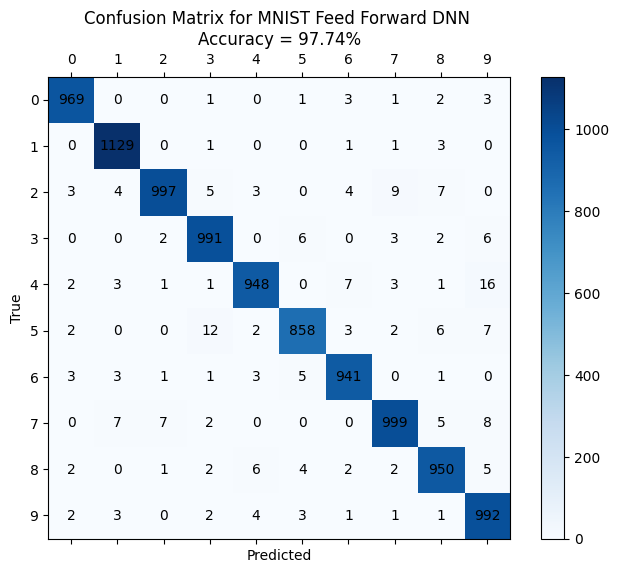

In [25]:
# Create matplotlib figure and fill in features for confusion matrix. 

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for MNIST Feed Forward DNN \nAccuracy = {100*accuracy:.2f}%')
for i in range(10):
    for j in range(10):
        ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

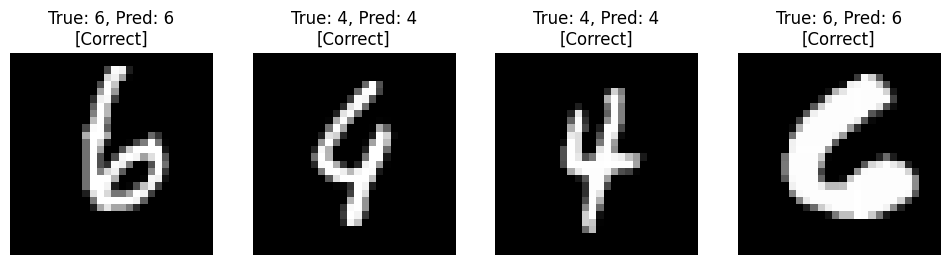

In [ ]:
# Visualize four sample predictions. 
# Display target and predicted labels. 

def visualize_samples():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    fig, axes = plt.subplots(1, 4, figsize=(12,3))
    for i in range(4):
        axes[i].imshow(images[i][0].cpu(), cmap='gray')  #  Move to CPU for display
        if labels[i].item() == preds[i].item(): 
            axes[i].set_title(f"True: {labels[i].item()}, Pred: {preds[i].item()}\n[Correct]")
        else: 
            axes[i].set_title(f"True: {labels[i].item()}, Pred: {preds[i].item()}\n[Not correct]")
        axes[i].axis('off')

visualize_samples()